In [12]:
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
import pandas as pd

In [5]:
db_config = {
    'host' : '172.31.98.107:27017,172.31.98.190:27017,172.31.98.6',
    'username' : 'admin',
    'password' : 'y3aJOBqfxsHu',
    'port' : 27017,
    'connectTimeoutMS' : 3000
}
database_name = 'xindong'
collect_name = 'user_watch_duration'

In [6]:
# mongodb session
db_ = MongoClient(**db_config)[database_name]

In [3]:
def query_by_datetime(start_date=None, end_date=None, collect_name=None, db_=None):
    # start_date <= t < end_date
    if start_date is not None and end_date is not None:
        start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
        nosql_query = {
            'createdAt': {
                    '$gte': start_date_dt,
                    '$lt': end_date_dt
                    }
        }
    else:
        nosql_query = {}
    watch_duration_data = list(db_[collect_name].find(nosql_query))
    return pd.DataFrame(watch_duration_data)


In [53]:
def calculateCTR(dat, threshold = 0, user_set=None):
    user2rec_info = dict()
    missing_user_num = 0
    match_user_num = 0
    for record in dat.to_dict('records'):
        userId = record['userId']
        if user_set is not None and userId not in user_set:
            missing_user_num +=1
            continue
        match_user_num +=1
        userId = record['userId']
        videoId = record['videoId']
        totalDuration = record['totalDuration']
        if userId not in user2rec_info:
            user2rec_info[userId] = {'pos' : [], 'neg' : []}
        if totalDuration >= threshold:
            user2rec_info[userId]['pos'].append(videoId)
        else:
            user2rec_info[userId]['neg'].append(videoId)
    unique_CTR = [0, 0]
    overall_CTR = [0, 0]
    user_list = list(user2rec_info.keys())
    for u in user_list:
        pos = user2rec_info[u]['pos']
        neg = user2rec_info[u]['neg']
        # overall
        overall_CTR[0] += len(pos)
        overall_CTR[1] += len(pos+neg)
        # unique
        unique_CTR[0] += len(set(pos))
        unique_CTR[1] += len(set(pos+neg))
    overall_CTR_ = overall_CTR[0] / overall_CTR[1]
    unique_CTR_ = unique_CTR[0] / unique_CTR[1]
    #if user_set is not None:
    #    print('missing_user_num : ', missing_user_num)
    #    print('match_user_num : ', match_user_num)
    #    print('-------')
    return overall_CTR_, unique_CTR_


In [14]:
start_date = '2022-12-28'
end_date = '2023-01-20'
date_list = [start_date]
while date_list[-1] != end_date:
    date_dt = datetime.strptime(date_list[-1], '%Y-%m-%d')
    date_dt += timedelta(days=1)
    date_list.append(date_dt.strftime('%Y-%m-%d'))

In [8]:
collect_name = 'user_watch_duration'

for i in range(len(date_list)-1):
    st = date_list[i]
    ed = date_list[i+1]
    dat = query_by_datetime('2022-12-28', '2022-12-29', collect_name, db_)

In [11]:
max(dat['createdAt'])

Timestamp('2022-12-28 23:59:52.195000')

In [ ]:
start_date = '2022-12-28'
end_date = '2023-01-08'
end_date = '2023-01-20'

In [ ]:
Timestamp('2022-12-28 09:42:31.395000')
ç

In [38]:
collect_name = 'user_recommend_medias'
start_date = None
end_date = None
rec_reuslt_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [39]:
rec_reuslt_dat.head(2)

,_id,userId,mediaIds,updatedAt
0,63adac0378b4fc28304e4a23,91693,"[21208,21373,21156,21483,19473,21448,21450,213...",0001-01-01 00:00:00
1,63adac0378b4fc28304e4a26,91776,"[97364,81988,47743,97347,82399,83305,34376,964...",0001-01-01 00:00:00


In [42]:
# build user2rec_result
user2rec_result = dict()
for record in rec_reuslt_dat.to_dict('records'):
    userId = record['userId']
    mediaIds = eval(record['mediaIds'])
    user2rec_result[userId] = mediaIds

In [43]:
rec_user_set = set(list(user2rec_result.keys()))

In [33]:
collect_name = 'user_watch_duration'
start_date = '2022-12-28'
end_date = '2023-01-08'
backend_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [34]:
collect_name = 'user_watch_duration'
start_date = '2023-01-08'
end_date = '2023-01-20'
ml_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [56]:
collect_name = 'user_watch_duration'
all_dat = query_by_datetime(None, None, collect_name, db_)
all_dat[['totalDuration']].describe([i/10 for i in range(10)])

,totalDuration
count,1.383270e+05
mean,4.707242e+02
std,6.302709e+04
min,1.000000e+00
0%,1.000000e+00
10%,2.000000e+00
20%,3.000000e+00
30%,4.000000e+00
40%,5.000000e+00
50%,5.000000e+00


In [35]:
ml_dat.head(2)

,_id,userId,videoId,totalDuration,parts,createdAt
0,63bf9f347ff01641a6e5c5d7,351066,87778,20.0,"[{""start"":0,""end"":20,""duration"":20}]",2023-01-12 05:48:36.583
1,63bf9f3406842f6333065f25,272471,96286,97.0,"[{""start"":0,""end"":97,""duration"":97}]",2023-01-12 05:48:36.183


In [ ]:
'''
1. filter user [easy]
2. filter video [difficult]
match_user_num = 24944
missing_user_num = 822
'''

In [61]:
threshold = [i for i in range(25)]
overall_CTR_bk, overall_CTR_ml = [], []
unique_CTR_bk, unique_CTR_ml = [], []
overall_CTR_diff, unique_CTR_diff = [], []
for thr in threshold:
    overall_ctr_bk_, unique_ctr_bk_ = calculateCTR(backend_dat, threshold = thr)
    overall_ctr_ml_, unique_ctr_ml_  = calculateCTR(ml_dat, threshold = thr, user_set=rec_user_set)
    overall_CTR_bk.append(overall_ctr_bk_)
    unique_CTR_bk.append(unique_ctr_bk_)
    overall_CTR_ml.append(overall_ctr_ml_)
    unique_CTR_ml.append(unique_ctr_ml_)
    # diff
    overall_CTR_diff.append(overall_ctr_ml_ - overall_ctr_bk_)
    unique_CTR_diff.append(unique_ctr_ml_ - unique_ctr_bk_)


In [60]:
print('overall_CTR_bk : ', overall_CTR_bk[:15])
print('overall_CTR_ml : ', overall_CTR_ml[:15])

overall_CTR_bk :  [1.0, 1.0, 0.9170599475625472, 0.8176598675732124, 0.7363551526463138, 0.6554326089854686, 0.4307781184730925, 0.41331378038483757, 0.39822245922765853, 0.38571745989423634, 0.3729813802604097, 0.3577834066568902, 0.3485668577522997, 0.33929698262453895, 0.33092476558681067]
overall_CTR_ml :  [1.0, 1.0, 0.9223460551635664, 0.8197161642078256, 0.7344852469531751, 0.6539849262347659, 0.4512107119948685, 0.4336914688903143, 0.4182969852469532, 0.4044259140474663, 0.39267960230917254, 0.3767238614496472, 0.3669820397690827, 0.35711994868505453, 0.3479393842206543]


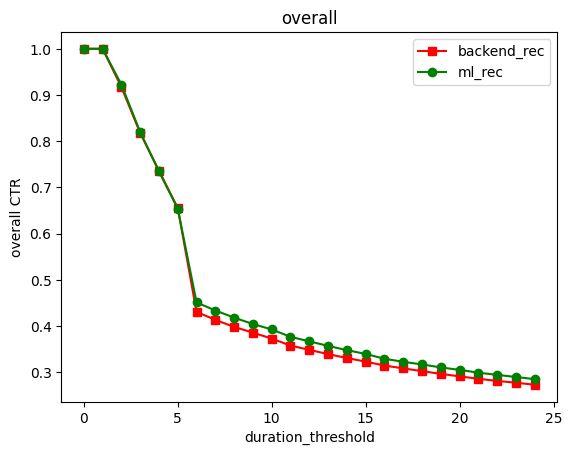

In [58]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(threshold,overall_CTR_bk,'s-',color = 'r', label="backend_rec")
plt.plot(threshold,overall_CTR_ml,'o-',color = 'g', label="ml_rec")

plt.title("overall")
plt.xlabel("duration_threshold")
plt.ylabel("overall CTR")
plt.legend()
plt.show()

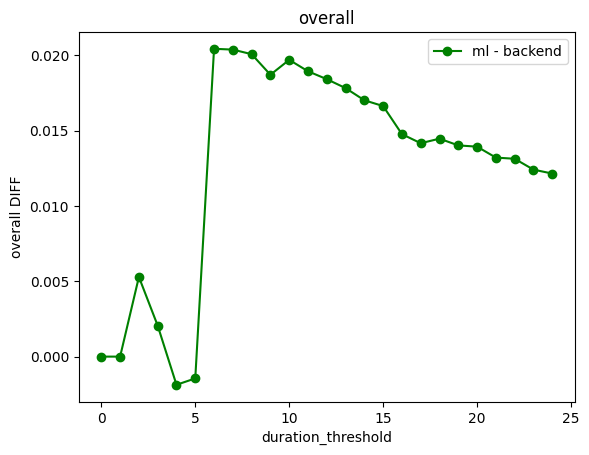

In [63]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(threshold,overall_CTR_diff,'o-',color = 'g', label="ml - backend")

plt.title("overall")
plt.xlabel("duration_threshold")
plt.ylabel("overall DIFF")
plt.legend()
plt.show()

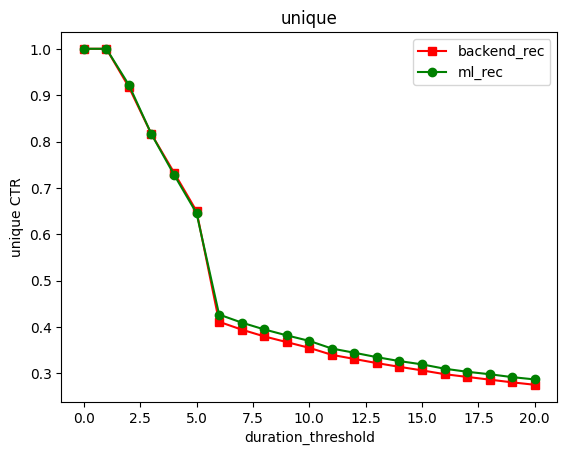

In [49]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


#plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
# 把資料放進來並指定對應的X軸、Y軸的資料，用方形做標記(s-)，並指定線條顏色為紅色，使用label標記線條含意
plt.plot(threshold,unique_CTR_bk,'s-',color = 'r', label="backend_rec")
# 把資料放進來並指定對應的X軸、Y軸的資料 用圓形做標記(o-)，並指定線條顏色為綠色、使用label標記線條含意
plt.plot(threshold,unique_CTR_ml,'o-',color = 'g', label="ml_rec")
 
# 設定圖片標題，以及指定字型設定，x代表與圖案最左側的距離，y代表與圖片的距離
plt.title("unique")
# 设置刻度字体大小
# 標示x軸(labelpad代表與圖片的距離)
plt.xlabel("duration_threshold")
# 標示y軸(labelpad代表與圖片的距離)
plt.ylabel("unique CTR")
# 顯示出線條標記位置
plt.legend()
# 畫出圖片
plt.show()

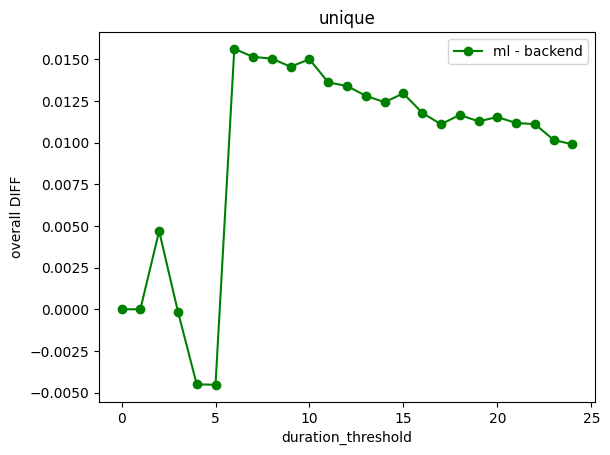

In [64]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(threshold,unique_CTR_diff,'o-',color = 'g', label="ml - backend")

plt.title("unique")
plt.xlabel("duration_threshold")
plt.ylabel("overall DIFF")
plt.legend()
plt.show()

In [32]:
collect_name = 'media'
media_data = list(db_[collect_name].find())
dat = pd.DataFrame(media_data)
used_media = set(dat[dat['contentType'].isin([1,2])]['_id'])

In [76]:
len(used_media)

5011

<AxesSubplot: >

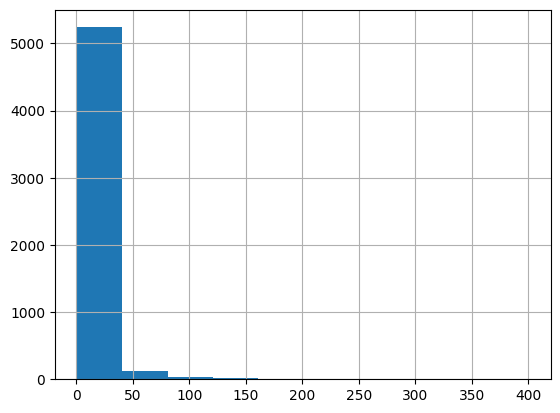

In [78]:
# query watch-duration data
collect_name = 'user_watch_duration'
all_watch_duration_data = list(db_[collect_name].find())
dat = pd.DataFrame(all_watch_duration_data)
dat = dat[dat['videoId'].isin(used_media)]

In [84]:
dat_ = dat.groupby(by=["userId"]).count()
dat_[['_id']].describe([i/10 for i in range(10)])

,_id
count,5422.000000
mean,9.366654
std,19.718790
min,1.000000
0%,1.000000
10%,1.000000
20%,2.000000
30%,2.000000
40%,3.000000
50%,4.000000


In [85]:
dat.shape

(50786, 6)

In [61]:
start_date = '2022-12-31'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
now_date_dt = datetime.now()
nosql_query = {
    'createdAt': {
            '$gte': start_date_dt,
            '$lt': now_date_dt
            }
}
watch_duration_data = list(db_[collect_name].find(nosql_query))
dat = pd.DataFrame(watch_duration_data)
used_user_set = set(dat[dat['videoId'].isin(used_media)]['userId'])

In [62]:
len(all_user_set & used_user_set) / len(all_user_set)

0.5111731843575419

In [63]:
len(all_user_set)

5370

In [64]:
len(used_user_set)

2771

In [39]:
min(dat['createdAt'])

Timestamp('2022-12-28 09:42:31.395000')

In [46]:
now_date_dt

datetime.datetime(2023, 1, 2, 14, 49, 53, 202626)

In [ ]:
'2023-01-01'
0.3016759776536313
-
'2022-12-31'
0.5111731843575419
-
'2022-12-30'
0.7219739292364991
-
'2022-12-29'
0.9070763500931098

In [72]:
start_date = '2022-12-28'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date = '2022-12-30'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
nosql_query = {
    'createdAt': {
            '$gte': start_date_dt,
            '$lt': end_date_dt
            }
}
watch_duration_data = list(db_[collect_name].find(nosql_query))
dat = pd.DataFrame(watch_duration_data)
used_user_setC = set(dat[dat['videoId'].isin(used_media)]['userId'])

In [ ]:
used_user_setA | ('2022-12-31', '2023-01-01')
used_user_setB | ('2022-12-30', '2022-12-31')
used_user_setC | ('2022-12-29', '2022-12-30')

In [75]:
len(used_user_setB & used_user_setC) / len(used_user_setB)

0.12481857764876633

In [70]:
len(used_user_setA)

1310

In [71]:
len(used_user_setB)

1378

In [74]:
len(used_user_setC)

1274

In [26]:
# query watch-duration data
collect_name = 'user_watch_duration'
all_watch_duration_data = list(db_[collect_name].find())
dat = pd.DataFrame(all_watch_duration_data)

In [40]:
collect_name = 'user_watch_duration'
all_watch_duration_data = list(db_[collect_name].find())
dat = pd.DataFrame(all_watch_duration_data)

In [41]:
min(dat['createdAt'])

Timestamp('2022-12-28 09:42:31.395000')

In [10]:
# given window and calculate cover rate

In [18]:
datetime.now()

datetime.datetime(2023, 1, 2, 14, 32, 13, 461156)

In [17]:
import pytz
zone_tz = pytz.timezone('Asia/Taipei')
date_dt = datetime.strptime(start_date, '%Y-%m-%d')
zone_tz.localize(date_dt).astimezone(pytz.utc)

datetime.datetime(2022, 12, 24, 16, 0, tzinfo=<UTC>)

In [15]:
all_watch_duration_data[:10]

[{'_id': ObjectId('63ac0f877ff01641a6e293dc'),
  'userId': 340660,
  'videoId': 96300,
  'totalDuration': 2.0,
  'parts': '[{"start":0,"end":2,"duration":2}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 42, 31, 395000)},
 {'_id': ObjectId('63ac0f948bbca5bbefb9b468'),
  'userId': 340660,
  'videoId': 32968,
  'totalDuration': 2.0,
  'parts': '[{"start":0,"end":2,"duration":2}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 42, 44, 516000)},
 {'_id': ObjectId('63ac0f9b8bbca5bbefb9b469'),
  'userId': 340660,
  'videoId': 92909,
  'totalDuration': 1.0,
  'parts': '[{"start":0,"end":1,"duration":1}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 42, 51, 607000)},
 {'_id': ObjectId('63ac0fe87ff01641a6e293e8'),
  'userId': 340660,
  'videoId': 92909,
  'totalDuration': 2.0,
  'parts': '[{"start":0,"end":2,"duration":2}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 44, 8, 837000)},
 {'_id': ObjectId('63ac0ff17ff01641a6e293ed'),
  'userId': 340660,
  'videoId': 92893,
  

In [ ]:
now_date = datetime.now().strftime('%Y-%m-%d')